<a href="https://colab.research.google.com/github/pushkar-khetrapal/DETR/blob/master/DETR_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/cocodataset/panopticapi.git
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-ymgbars9
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-ymgbars9
  Created wheel for panopticapi: filename=panopticapi-0.1-cp36-none-any.whl size=8317 sha256=a5a8c0fc1df995167ad1bb0781915653dccbe307c5ff9ead43d16f25d8b58c6a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ra8ziqlf/wheels/41/ae/17/f7e628e1ba4776ceea035aefb113ef24b6639ad5d5a2e5a5d1
Successfully built panopticapi
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 6.9MB/s 
     |████████████████████████████████| 276kB 12.7MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=e65d47b71bd0e37048f5a712ed636d807a12237c4b1504b8923681c58d18e183
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
  Created wheel 

In [ ]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy as np
import cv2
import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False);

import panopticapi
from panopticapi.utils import id2rgb, rgb2id

import matplotlib.pyplot as plt

import itertools
import seaborn as sns

from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

from copy import deepcopy

# These are the COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# Detectron2 uses a different numbering scheme, we build a conversion table
coco2d2 = {}
count = 0
for i, c in enumerate(CLASSES):
  if c != "N/A":
    coco2d2[i] = count
    count+=1

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet101_panoptic', pretrained=True, return_postprocessor=True, num_classes=250)
model.eval();
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)
# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-panoptic-40021d53.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-panoptic-40021d53.pth



cuda


In [ ]:
def detr(im):
  im = Image.fromarray(np.uint8(im)).convert('RGB')
  img = transform(im).unsqueeze(0)
  img = img.to('cuda')
  out = model(img)
  # compute the scores, excluding the "no-object" class (the last one)
  scores = out["pred_logits"].softmax(-1)[..., :-1].max(-1)[0]
  # threshold the confidence
  keep = scores > 0.85
  # the post-processor expects as input the target size of the predictions (which we set here to the image size)
  result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

  palette = itertools.cycle(sns.color_palette())

  # The segmentation is stored in a special-format png
  panoptic_seg = Image.open(io.BytesIO(result['png_string']))
  panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()

  # We retrieve the ids corresponding to each mask
  panoptic_seg_id = rgb2id(panoptic_seg)

  # Finally we color each mask individually
  panoptic_seg[:, :, :] = 0
  for id in range(panoptic_seg_id.max() + 1):
    panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255

  # We extract the segments info and the panoptic result from DETR's prediction
  segments_info = deepcopy(result["segments_info"])
  # Panoptic predictions are stored in a special format png
  panoptic_seg = Image.open(io.BytesIO(result['png_string']))
  final_w, final_h = panoptic_seg.size
  # We convert the png into an segment id map
  panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
  panoptic_seg = torch.from_numpy(rgb2id(panoptic_seg))


  for i in range(len(segments_info)):
      c = segments_info[i]["category_id"]
      segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]
  # Finally we visualize the prediction
  v = Visualizer(numpy.array(im.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)

  v._default_font_size = 20
  v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
  return v.get_image()

In [ ]:
!wget http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_MPEG2.mpg

--2020-07-28 06:47:18--  http://s150102174.onlinehome.fr/Lara/files/Lara_UrbanSeq1_MPEG2.mpg
Resolving s150102174.onlinehome.fr (s150102174.onlinehome.fr)... 217.160.0.161
Connecting to s150102174.onlinehome.fr (s150102174.onlinehome.fr)|217.160.0.161|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208220164 (199M) [video/mpeg]
Saving to: ‘Lara_UrbanSeq1_MPEG2.mpg’

Lara_UrbanSeq1_MPEG 100%[===================>] 198.57M  4.82MB/s    in 44s     

2020-07-28 06:48:03 (4.52 MB/s) - ‘Lara_UrbanSeq1_MPEG2.mpg’ saved [208220164/208220164]



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [30]:
import cv2 

video = cv2.VideoCapture('/content/Lara_UrbanSeq1_MPEG2.mpg')
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

# We need to check if camera 
# is opened previously or not 
if (video.isOpened() == False): 
	print("Error reading video file") 

# We need to set resolutions. 
size = (width, height) 

count = 1
# Below VideoWriter object will create 
# a frame of above defined The output 
# is stored in 'filename.avi' file. 
writer = cv2.VideoWriter('final.mp4', 
						cv2.VideoWriter_fourcc(*'DIVX'), 
						20, size)

while(True): 
  ret, frame = video.read()
  print(count)
  if ret == True:

    z = detr(frame) 
    cv2.imwrite("/content/drive/My Drive/DrivingImages/{}.jpg".format(count),z)
    count = count + 1
    #cv2_imshow(detr(frame))
    # Break the loop 

  else:
    break

# When everything done, release 
# the video capture and video 
# write objects 
video.release() 
writer.release() 

# Closes all the frames 
cv2.destroyAllWindows() 

print("The video was successfully saved") 

1


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Streaming output truncated to the last 5000 lines.
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199
6200
6201
6202
6203
6204
6205
6206
6207
6208
6209
6210
6211
6212
6213
6214
6215
6216
6217
6218
6219
6220
6221
6222
6223
6224
6225
6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329
6330
6331
6332
6333
6334
6335
6336
6337
6338
6339
6340
6341
6342
6343
6344
6345
6346
6347
6348
6349
6350
6351
6352
6353
6354
6355
6356
6357
6358
6359
6360
6361

In [41]:
out = cv2.VideoWriter('/content/drive/My Drive/Ottonomy IO/myVideo.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 30, (800, 1066))
 
for i in range(1, 11):
    img = cv2.imread("/content/drive/My Drive/DrivingImages/{}.jpg".format(count))
    out.write(img)
out.release()

In [46]:
import os
import moviepy.video.io.ImageSequenceClip
image_folder='/content/drive/My Drive/DrivingImages'
fps=30

image_files = [image_folder+'/'+img for img in os.listdir(image_folder) if img.endswith(".jpg")]
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files[80:1200], fps=fps)
clip.write_videofile('/content/drive/My Drive/Ottonomy IO/myVideo123.mp4')

[MoviePy] >>>> Building video /content/drive/My Drive/Ottonomy IO/myVideo123.mp4
[MoviePy] Writing video /content/drive/My Drive/Ottonomy IO/myVideo123.mp4


100%|██████████| 1121/1121 [01:27<00:00, 12.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /content/drive/My Drive/Ottonomy IO/myVideo123.mp4 



In [36]:
x  =cv2.imread("/content/drive/My Drive/DrivingImages/{}.jpg".format(1))

In [40]:
x.shape

(800, 1066, 3)

In [ ]:
cv2.imwrite("/content/images/{}.jpg".format('hii'),z)

True

In [ ]:
"/content/images/{}.jpg".format('hii')

'/content/images/hii.jpg'

In [ ]:
import cv2
im = cv2.imread('/content/x.jpg')

In [ ]:
im.shape


(177, 284, 3)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


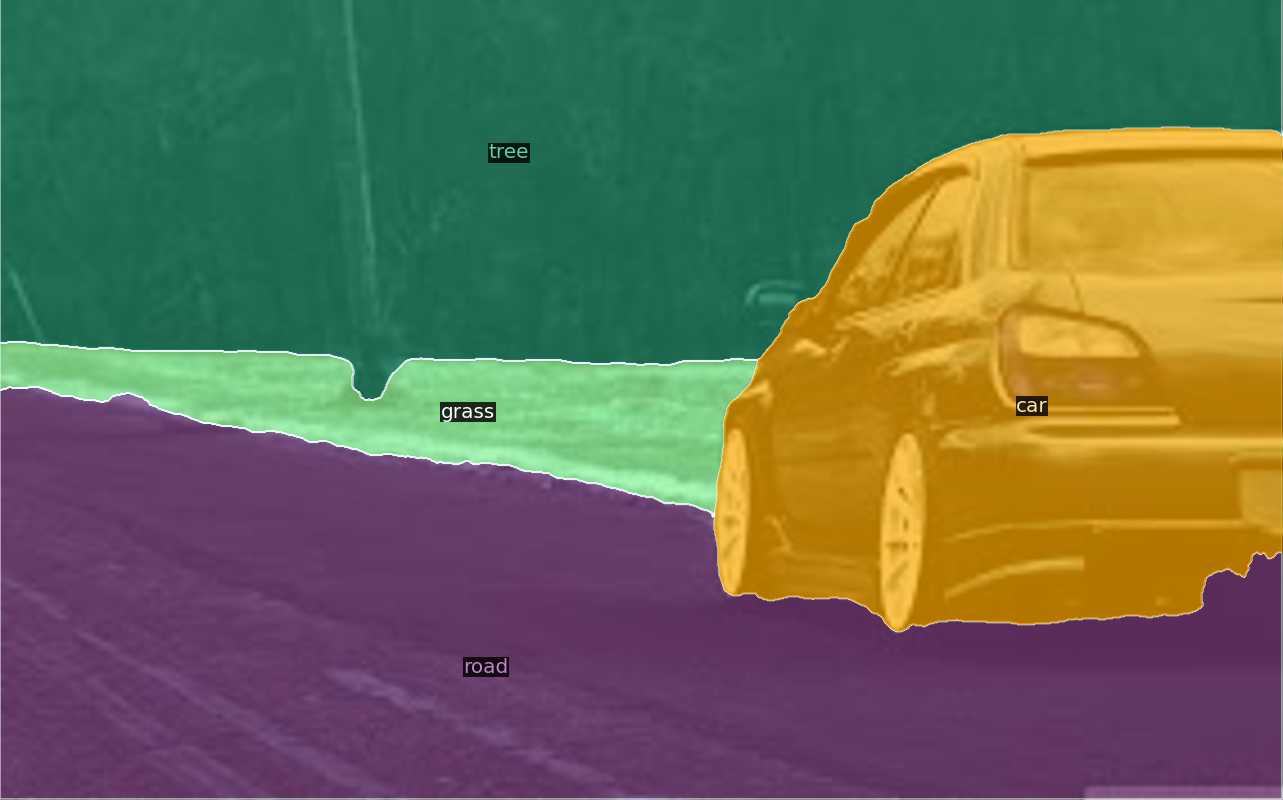

In [ ]:
cv2_imshow(detr(im))

In [ ]:
import numpy as np
im.reshape(1, 3, im.shape[0], im.shape[1])

array([[[[ 35,  40,  39, ...,  35,  39,  44],
         [ 42,  38,  43, ...,  29,  27,  27],
         [ 30,  28,  28, ...,  21,  24,  22],
         ...,
         [ 26,  31,  29, ...,   6,  12,  18],
         [ 17,  13,  19, ...,   9,   7,  10],
         [ 21,  19, 108, ..., 150, 186, 196]],

        [[ 22,  27,  25, ...,   4,   8,  14],
         [ 13,   7,  13, ...,   2,   0,  97],
         [108, 106, 157, ..., 150, 188, 200],
         ...,
         [ 42,  53,  51, ...,  48,  42,  51],
         [ 48,  42,  51, ...,   7,   8,   5],
         [  7,   8,   4, ..., 135, 149, 155]],

        [[ 31,  42,  40, ...,  48,  42,  51],
         [ 48,  42,  51, ...,   7,   7,   7],
         [  7,   7,   6, ...,  46,  56,  56],
         ...,
         [ 21,  26,  24, ...,  29,  24,  24],
         [ 24,  25,  27, ...,  47,  44,  42],
         [ 51,  48,  27, ..., 148, 149, 147]]]], dtype=uint8)